In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.preprocessing import StandardScaler

In [2]:
train_dataset = pd.read_csv('/kaggle/input/playground-series-s4e6/train.csv')
test_dataset = pd.read_csv('/kaggle/input/playground-series-s4e6/test.csv')

In [3]:
from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder()

train_dataset['Target'] = label_encoder.fit_transform(train_dataset['Target']) 
  
train_dataset['Target'].unique() 

# 2 for Graduate, 0 for Dropout, and 1 for Enrolled

array([2, 0, 1])

### Filter Features Method


In [4]:
def filter_features(dataset):
    plt.figure(figsize=(train_dataset.shape[1],10))
    cor = dataset.corr()
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.show()
    
    #Selecting highly correlated features
    cor_target = abs(cor["Target"])
    relevant_features = cor_target[cor_target>=0.3]
    
    return relevant_features

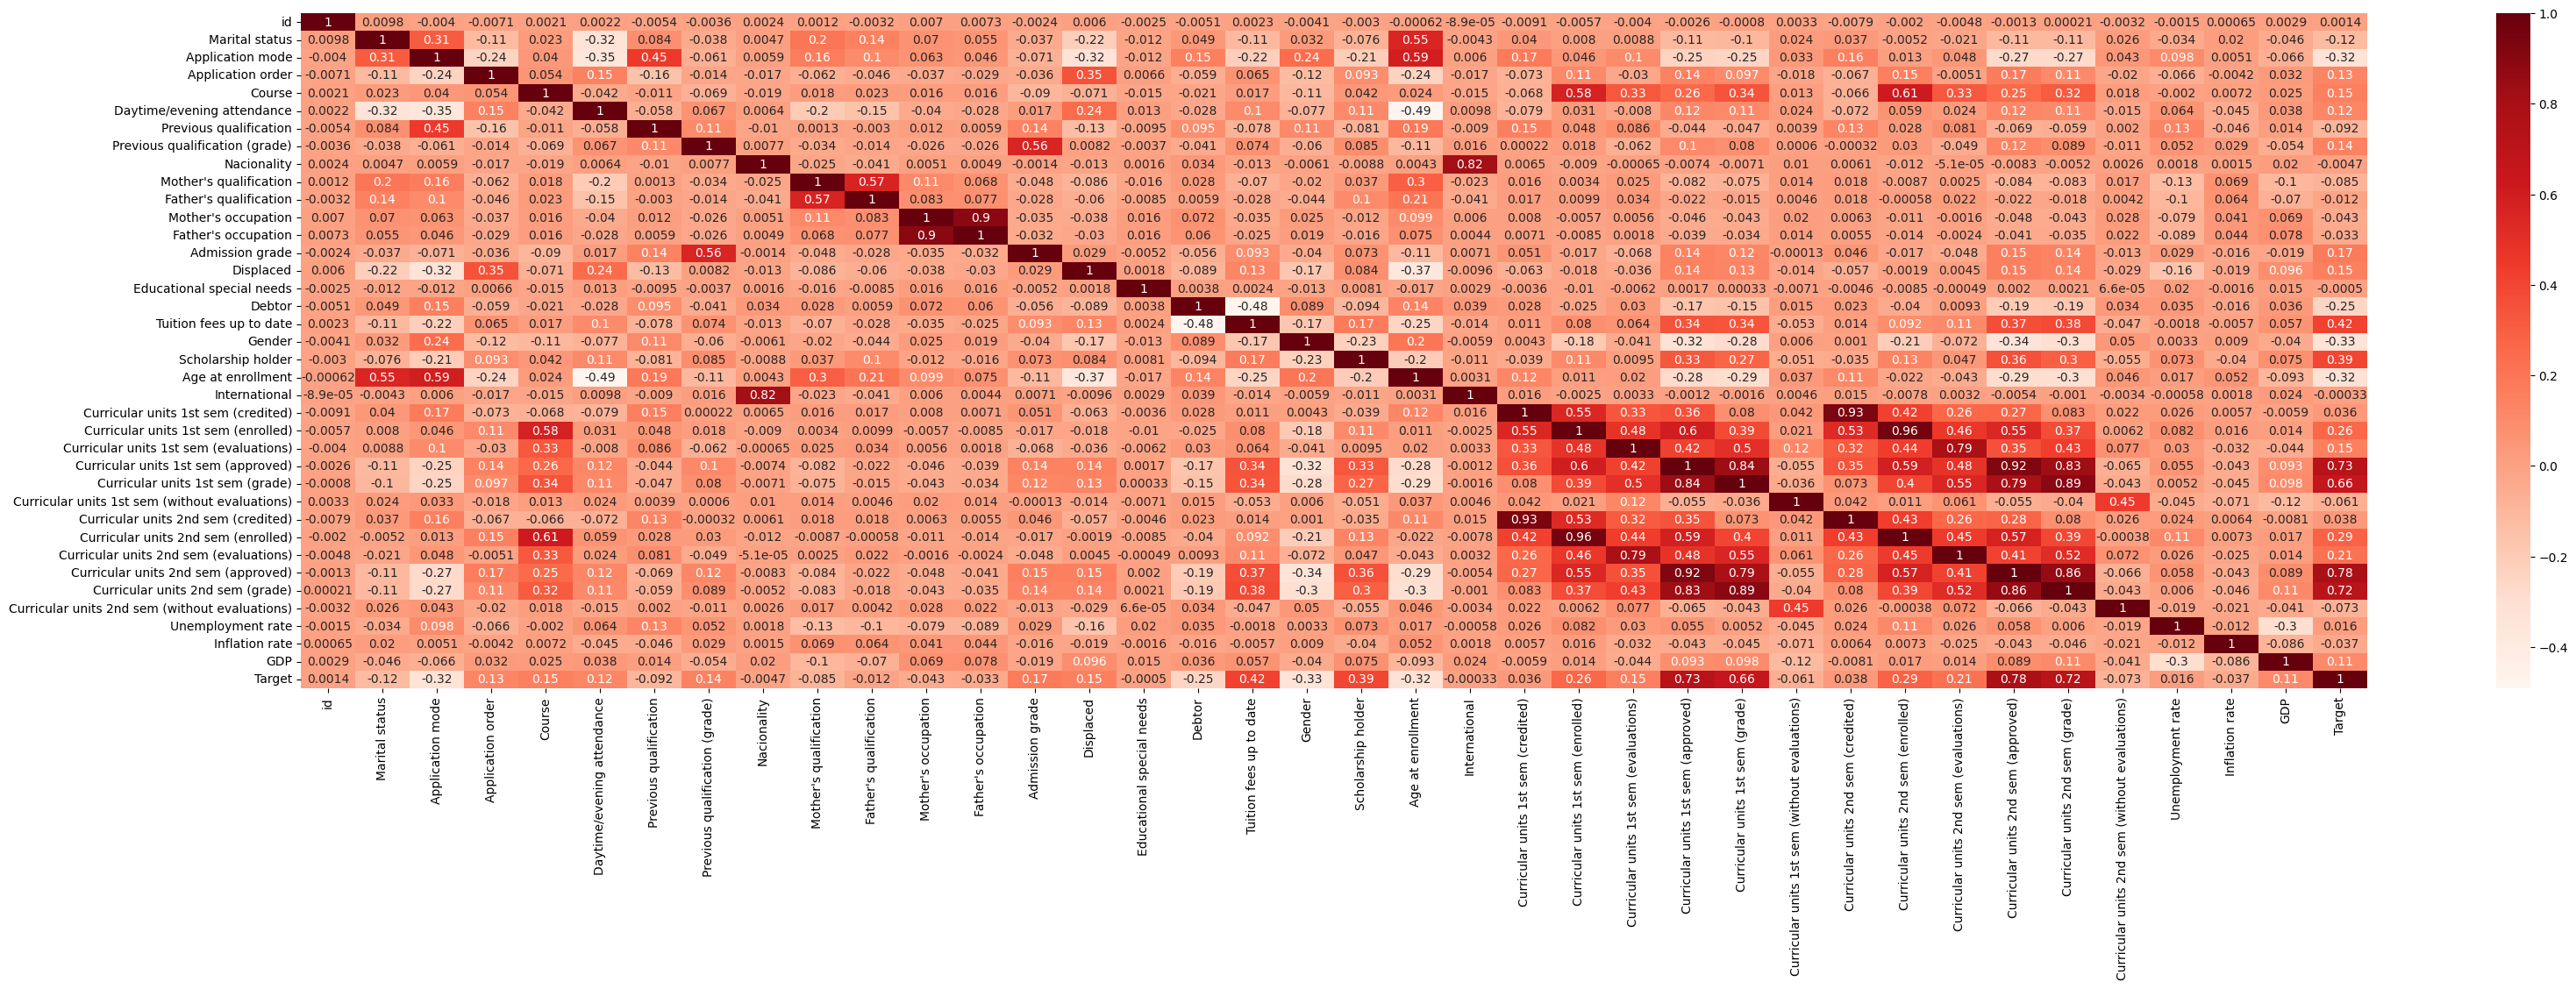

In [5]:
relevant_features = filter_features(train_dataset)

In [6]:
relevant_features

Application mode                       0.324830
Tuition fees up to date                0.415691
Gender                                 0.330181
Scholarship holder                     0.394124
Age at enrollment                      0.320679
Curricular units 1st sem (approved)    0.725490
Curricular units 1st sem (grade)       0.661355
Curricular units 2nd sem (approved)    0.781452
Curricular units 2nd sem (grade)       0.719036
Target                                 1.000000
Name: Target, dtype: float64

In [7]:
train_dataset.columns

Index(['id', 'Marital status', 'Application mode', 'Application order',
       'Course', 'Daytime/evening attendance', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units

In [8]:
train_dataset = train_dataset.drop(["Nacionality","Father's qualification","Educational special needs",
                                  "International","Unemployment rate","id", "Mother's qualification"], axis=1) 

In [9]:
test_dataset = test_dataset.drop(["Nacionality","Father's qualification","Educational special needs",
                                  "International","Unemployment rate","id", "Mother's qualification"], axis=1) 

In [10]:
train_dataset.shape

(76518, 31)

In [11]:
from sklearn.model_selection import train_test_split
X = train_dataset.drop(['Target'],axis=1)
y = train_dataset['Target']

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
classifier = LogisticRegression(random_state=0, max_iter=500)
classifier.fit(X_train,y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=500, random_state=0)

In [14]:
prediction=classifier.predict(X_val)

In [15]:
acc_score = accuracy_score(y_val , prediction)
acc_score

0.7828018818609513

In [16]:
from xgboost import XGBClassifier

clf_xg = XGBClassifier(eval_metric = 'logloss')
clf_xg.fit(X_train,y_train)

xgb_pred = clf_xg.predict(X_val)
xgb_score=accuracy_score(y_val,xgb_pred)
print(f"Validation Accuracy XGB is : {(xgb_score)}")

Validation Accuracy XGB is : 0.8319393622582332


In [17]:
y_pred = clf_xg.predict(test_dataset)

In [18]:
y_pred

array([0, 2, 2, ..., 0, 0, 0])

In [19]:
yhat_cat = []
for i in range(len(y_pred)):
    if y_pred[i] == 0:
        yhat_cat.append('Dropout')
    elif y_pred[i] == 1:
        yhat_cat.append('Enrolled')
    else:
        yhat_cat.append('Graduate')

In [20]:
submit = pd.read_csv('/kaggle/input/playground-series-s4e6/sample_submission.csv')
submit.Target = yhat_cat
submit[['id', 'Target']].to_csv('/kaggle/working/xgboost.csv', index=False)

### Optimizing the XGboost model


In [38]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [39]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}

xgb_model = xgb.XGBClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 7, 'subsample': 1}
Best score:  0.8298102161288903


In [40]:
clf_xg = XGBClassifier(learning_rate = 0.1, max_depth = 7, subsample = 1,
                       eval_metric = 'logloss')
clf_xg.fit(X_train,y_train)

xgb_pred = clf_xg.predict(X_val)
xgb_score=accuracy_score(y_val,xgb_pred)
print(f"Validation Accuracy XGB is : {(xgb_score)}")

Validation Accuracy XGB is : 0.8318740198640878


In [41]:
y_pred = clf_xg.predict(test_dataset)

In [42]:
yhat_cat = []
for i in range(len(y_pred)):
    if y_pred[i] == 0:
        yhat_cat.append('Dropout')
    elif y_pred[i] == 1:
        yhat_cat.append('Enrolled')
    else:
        yhat_cat.append('Graduate')

In [43]:
submit = pd.read_csv('/kaggle/input/playground-series-s4e6/sample_submission.csv')
submit.Target = yhat_cat
submit[['id', 'Target']].to_csv('/kaggle/working/xgboost_tunning.csv', index=False)